# _PyChOpMarg_ vs. MATLAB

Original author: David Banas <capn.freako@gmail.com>  
Original date:   January 24, 2025

Copyright &copy; 2025 David Banas; all rights reserved World wide.

## Introduction

This [Jupyter](https://jupyter.org) notebook is intended to provide a comparison between the MATLAB COM code and the public-domain, open-source [_PyChOpMarg_](https://pychopmarg.readthedocs.io/en/latest/index.html) Python package, which provides an alternative to the MATLAB COM code for those, who prefer to work in Python.

I run it from my `pychopmarg` Python virtual environment, into which I've installed:

- `jupyter`
- `PyChOpMarg`
- `matplotlib`
- `xlrd`

This notebook uses certain example channels pertinent to the work of the IEEE 802.3dj task force.

**Note:** The _PyChOpMarg_ package is not affiliated with the IEEE or its 802.3 working group in any way.

In [1]:
%%html
<style>
.jp-RenderedHTMLCommon pre, .jp-RenderedHTMLCommon code {
  background-color: #eef;
}
</style>

## Imports & Aliases

Here, we import everything we need and define some useful type aliases.


In [2]:
%matplotlib inline

import cProfile
import pickle
import re

import numpy    as np
import skrf     as rf

from dataclasses        import fields
from enum               import Enum
from matplotlib         import pyplot as plt
from matplotlib.axes    import Axes
from matplotlib.ticker  import MultipleLocator
from numpy.fft          import fftshift, irfft, rfft
from pathlib            import Path
from random             import choice, sample
from scipy.interpolate  import interp1d
from time               import time
from typing             import Any, Callable, Dict, Optional, TypeAlias

from pychopmarg.com         import COM, run_com
from pychopmarg.common      import *
from pychopmarg.config.ieee_8023dj import IEEE_8023dj
from pychopmarg.config.template import COMParams
from pychopmarg.excel       import get_com_params
from pychopmarg.matlab      import run_com_matlab
from pychopmarg.optimize    import NormMode
from pychopmarg.plot        import plot_group_samps, plot_pulse_resps_gen, ZoomMode
from pychopmarg.utility import(
    calc_Hffe, dBm_Hz, from_irfft, fwhm, get_channel_sets, mag_dB,
    reflectivity, s2p_pulse_response)

# Global initialization
np.set_printoptions(precision=2, linewidth=200)

## COM Parameter Values

The MS Excel spreadsheet used to configure the COM run for both tools can be found in the GitHub repo. for the _PyChOpMarg_ package:

[MS Excel configuration spreadsheet](https://github.com/capn-freako/PyChOpMarg/blob/eca2c36f579b38cbb36cc5032c0ff5e296590d67/config_com_ieee8023dj_PyChOpMarg_vs_MATLAB.xls)


In [3]:
COM_CFG_SHEET = '../config/config_com_ieee8023dj_PyChOpMarg_vs_MATLAB.xls'
com_params = get_com_params(Path(COM_CFG_SHEET))


In [4]:
for field in fields(com_params):
    print(f"{field.name}: {getattr(com_params, field.name)}")

fb: 106.25
fstep: 0.05
L: 4
M: 32
DER_0: 0.0002
T_r: 0.004
RLM: 0.95
A_v: 0.413
A_fe: 0.413
A_ne: 0.45
R_0: 50
A_DD: 0.02
SNR_TX: 33
eta_0: 6e-09
sigma_Rj: 0.01
f_z: 1000
f_p1: 1000
f_p2: 1000
f_LF: 1.328125
g_DC: [0]
g_DC2: [0]
tx_taps_min: [0, 0, 0, 0, 0.0, 0.0]
tx_taps_max: [0, 0, 0, 0, 0.0, 0.0]
tx_taps_step: [0, 0, 0, 0, 0.0, 0.0]
c0_min: 1
f_r: 0.58
dfe_min: [0.]
dfe_max: [0.85]
rx_taps_min: [-1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
rx_taps_max: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
dw: 5
R_d: [50. 50.]
C_d: [[4.0e-05 9.0e-05 1.1e-04]
 [4.0e-05 9.0e-05 1.1e-04]]
C_b: [3.e-05 3.e-05]
C_p: [4.e-05 4.e-05]
L_s: [[0.13 0.15 0.14]
 [0.13 0.15 0.14]]
z_c: [87.5, 92.5]
z_p: [33, 1.8]
gamma0: 0.0005
a1: 0.00089
a2: 0.0002
tau: 0.006141
z_pB: 1.8


## Identify and Run Channel Sets

Given a top-level directory, assemble the dictionary of groups of "channel sets" available for testing.  
Then, select a subset of these for simulation and run them.

A _group_ of channel sets is created for each subdirectory found.

A _channel set_ consists of:

- a thru channel,
- some number of NEXT aggressors, and
- some number of FEXT aggressors.

NEXT/FEXT aggressors are associated with thru channels, via simple file name pattern matching, substituting "next"/"fext" in for "thru".

**Note:** You can find the channels contributed for work on 802.3dj here:  
[IEEE P802.3dj Tools and Channel Data Area (After 27 Jan 2024)](https://www.ieee802.org/3/dj/public/tools/index.html)


In [5]:
top_dir = Path("../chnl_data/P8023dj/KR")
channel_sets = get_channel_sets(top_dir)
print(f"Channel groups found in '{top_dir}':")
for grp, chnls in channel_sets.items():
    print(f"\t{grp:30s}:\t{len(chnls):4d} channels found.")


Channel groups found in '../chnl_data/P8023dj/KR':
	mellitz_3dj_02_elec_230504    :	  27 channels found.
	mellitz_3dj_03_elec_230504    :	  25 channels found.
	shanbhag_3dj_02_2305          :	   4 channels found.
	weaver_3dj_02_2305            :	  36 channels found.


In [6]:
class ChnlSel(Enum):
    "Test channel selection mode."
    FULL      = 1  # Use all available test channels.
    RANDOM    = 2  # Use `N_RAND` randomly selected channels. (See below.)
    GROUP     = 3  # Use all channels in group: `GRP_NAME`.
    GROUP_SUB = 4  # Use channels: `CHNL_NUMS`, from group: `GRP_NAME`.
    CHANNELS  = 5  # Use channels: `CHNL_NAMES`, from group: `GRP_NAME`.
    RAND_ALL  = 6  # Use `N_RAND` randomly selected channels from each available group.
    PREVIOUS  = 7  # Use channels from last run.

# Change these, to customize the run of this notebook:
channel_selection_mode = ChnlSel(ChnlSel.RAND_ALL)
N_RAND:     int       = 3                             # Number of channels used in `RANDOM`  and `RAND_ALL` modes.
GRP_NAME:   str       = "weaver_3dj_02_2305"          # Name of group used in `GROUP`, `GROUP_SUB`, and `CHANNELS` modes.
CHNL_NUMS:  list[int] = range(1, 3)                   # Channel selection indices used in `GROUP_SUB` mode.
                                                      # Channel names used in `CHANNELS` mode:
CHNL_NAMES: list[str] = ["KR_ch_3in_PCB_NPC_150mm_29AWG_BP_800mm_27AWG_NPC_150mm_29AWG_thru"]  # ,
                         # "KRCA_wXTALK_MX_16_PCB-25-25_mm_FO-300-300_mm_CA-500_mm_thru"]

# DON'T CHANGE ANYTHING ELSE BELOW THIS LINE, IN THIS CELL!

# The full set of available test channels:
ch_sets = [(k, chnl_set) for k, v in channel_sets.items()
                         for chnl_set in v]

# The subset of the above that we'll use in this notebook:
match channel_selection_mode:
    case ChnlSel.FULL:
        tested_ch_sets = ch_sets
    case ChnlSel.RANDOM:
        tested_ch_sets = sample(ch_sets, N_RAND)
    case ChnlSel.GROUP:
        tested_ch_sets = [(GRP_NAME, ch_set) for ch_set in channel_sets[GRP_NAME]]
    case ChnlSel.GROUP_SUB:
        tested_ch_sets = [(GRP_NAME, channel_sets[GRP_NAME][n]) for n in CHNL_NUMS]
    case ChnlSel.CHANNELS:
        tested_ch_sets = [(GRP_NAME, cset) for cset in filter(lambda cs: cs['THRU'][0].stem in CHNL_NAMES, channel_sets[GRP_NAME])]
    case ChnlSel.RAND_ALL:
        tested_ch_sets = [(grp, ch_set) for grp in sorted(channel_sets.keys()) for ch_set in sample(channel_sets[grp], N_RAND)]
    case ChnlSel.PREVIOUS:
        with open("tested_ch_sets.pickle", "rb") as dump_file:
            tested_ch_sets = pickle.load(dump_file)
    case _:
        raise ValueError(f"Unrecognized channel selection mode: {channel_selection_mode}, requested!")

nTests = len(tested_ch_sets)
print(f"{nTests} channel(s) selected for testing.")


12 channel(s) selected for testing.


In [7]:
USE_OLD_DATA  = False   # Set to `False` to re-run the simulation.
# SAVE_NEW_DATA = False  # Set to `True` to save new simulation data for future use.
SAVE_NEW_DATA = channel_selection_mode == ChnlSel.FULL or channel_selection_mode == ChnlSel.RAND_ALL
DBG = True

if DBG:
    dbg_dict = {}
else:
    dbg_dict = None

if USE_OLD_DATA:
    with open("tested_ch_sets.pickle", "rb") as dump_file:
        tested_ch_sets = pickle.load(dump_file)
    with open("theCOMs_MMSE.pickle", "rb") as dump_file:
        theCOMs = pickle.load(dump_file)
    with open("theCOMs_PRZF.pickle", "rb") as dump_file:
        _theCOMs = pickle.load(dump_file)
else:
    norm_mode = NormMode.P8023dj
    start_time = time()
    theCOMs  = run_com(tested_ch_sets, com_params, norm_mode=norm_mode, dbg_dict=dbg_dict)
    stop_time = time()
    print(f"Run time: {(stop_time  - start_time) / 60.} minutes")

if not USE_OLD_DATA and SAVE_NEW_DATA:
    with open("tested_ch_sets.pickle", "wb") as dump_file:
        pickle.dump(tested_ch_sets, dump_file)
    with open("theCOMs_MMSE.pickle", "wb") as dump_file:
        pickle.dump(theCOMs, dump_file)


mellitz_3dj_02_elec_230504 : KRCA_wXTALK_MX_16_PCB-25-25_mm_FO-300-300_mm_CA-500_mm_thru


mellitz_3dj_02_elec_230504 : KRCA_wXTALK_MX_11_PCB-50-50_mm_FO-100-100_mm_CA-500_mm_thru


mellitz_3dj_02_elec_230504 : KRCA_wXTALK_MX_12_PCB-75-75_mm_FO-100-100_mm_CA-500_mm_thru


mellitz_3dj_03_elec_230504 : C2C_withXtalk_Mezz_4_PCB-130mm_25mm_thru


mellitz_3dj_03_elec_230504 : C2C_withXtalk_Mezz_20_PCB-200mm_130mm_thru


mellitz_3dj_03_elec_230504 : C2C_withXtalk_Mezz_10_PCB-200mm_60mm_thru


shanbhag_3dj_02_2305 : KR_1mCabledBP_TP0TP5_28dB_PCBHost_8dB_THRU


shanbhag_3dj_02_2305 : KR_1mCabledBP_TP0TP5_31p4dB_PCBHost_9p8dB_THRU


shanbhag_3dj_02_2305 : KR_1mCabledBP_TP0TP5_19p3dB_PCBHost_3p8dB_THRU


weaver_3dj_02_2305 : KR_ch_3in_PCB_NPC_350mm_29AWG_BP_800mm_27AWG_NPC_350mm_29AWG_thru


weaver_3dj_02_2305 : KR_ch_3in_PCB_NPC_250mm_29AWG_BP_800mm_27AWG_NPC_400mm_29AWG_thru


weaver_3dj_02_2305 : KR_ch_3in_PCB_NPC_300mm_29AWG_BP_800mm_27AWG_NPC_400mm_29AWG_thru


Run time: 1.0194989522298177 minutes


## MATLAB vs. _PyChOpMarg_

Let's compare the MATLAB results to our _PyChOpMarg_ results.  
As per the request made in D1.2, we'll use the new v4.70 version of the M-code.  
The commands are dumped, as a convenience, in case we need to go into MATLAB and debug something.


In [8]:
MATLAB_EXEC = Path("/Applications/MATLAB_R2024b.app/bin/matlab")  # Mac
# MATLAB_EXEC = Path("C:/Program Files/MATLAB/R2024b/bin/matlab.exe")  # PC
matlab_results = run_com_matlab(tested_ch_sets, COM_CFG_SHEET, MATLAB_EXEC)


Command:
com_ieee8023_93a('../config/config_com_ieee8023dj_PyChOpMarg_vs_MATLAB.xls', 5, 3, '../chnl_data/P8023dj/KR/mellitz_3dj_02_elec_230504/KRCA_wXTALK_MX_16_PCB-25-25_mm_FO-300-300_mm_CA-500_mm_thru.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_02_elec_230504/KRCA_wXTALK_MX_16_PCB-25-25_mm_FO-300-300_mm_CA-500_mm_fext1.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_02_elec_230504/KRCA_wXTALK_MX_16_PCB-25-25_mm_FO-300-300_mm_CA-500_mm_fext2.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_02_elec_230504/KRCA_wXTALK_MX_16_PCB-25-25_mm_FO-300-300_mm_CA-500_mm_fext3.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_02_elec_230504/KRCA_wXTALK_MX_16_PCB-25-25_mm_FO-300-300_mm_CA-500_mm_fext4.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_02_elec_230504/KRCA_wXTALK_MX_16_PCB-25-25_mm_FO-300-300_mm_CA-500_mm_fext5.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_02_elec_230504/KRCA_wXTALK_MX_16_PCB-25-25_mm_FO-300-300_mm_CA-500_mm_next1.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_02_elec_230504/KRCA_wXTALK_MX_16_PCB-2


Command:
com_ieee8023_93a('../config/config_com_ieee8023dj_PyChOpMarg_vs_MATLAB.xls', 5, 3, '../chnl_data/P8023dj/KR/mellitz_3dj_02_elec_230504/KRCA_wXTALK_MX_11_PCB-50-50_mm_FO-100-100_mm_CA-500_mm_thru.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_02_elec_230504/KRCA_wXTALK_MX_11_PCB-50-50_mm_FO-100-100_mm_CA-500_mm_fext1.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_02_elec_230504/KRCA_wXTALK_MX_11_PCB-50-50_mm_FO-100-100_mm_CA-500_mm_fext2.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_02_elec_230504/KRCA_wXTALK_MX_11_PCB-50-50_mm_FO-100-100_mm_CA-500_mm_fext3.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_02_elec_230504/KRCA_wXTALK_MX_11_PCB-50-50_mm_FO-100-100_mm_CA-500_mm_fext4.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_02_elec_230504/KRCA_wXTALK_MX_11_PCB-50-50_mm_FO-100-100_mm_CA-500_mm_fext5.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_02_elec_230504/KRCA_wXTALK_MX_11_PCB-50-50_mm_FO-100-100_mm_CA-500_mm_next1.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_02_elec_230504/KRCA_wXTALK_MX_11_PCB-5


Command:
com_ieee8023_93a('../config/config_com_ieee8023dj_PyChOpMarg_vs_MATLAB.xls', 5, 3, '../chnl_data/P8023dj/KR/mellitz_3dj_02_elec_230504/KRCA_wXTALK_MX_12_PCB-75-75_mm_FO-100-100_mm_CA-500_mm_thru.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_02_elec_230504/KRCA_wXTALK_MX_12_PCB-75-75_mm_FO-100-100_mm_CA-500_mm_fext1.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_02_elec_230504/KRCA_wXTALK_MX_12_PCB-75-75_mm_FO-100-100_mm_CA-500_mm_fext2.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_02_elec_230504/KRCA_wXTALK_MX_12_PCB-75-75_mm_FO-100-100_mm_CA-500_mm_fext3.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_02_elec_230504/KRCA_wXTALK_MX_12_PCB-75-75_mm_FO-100-100_mm_CA-500_mm_fext4.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_02_elec_230504/KRCA_wXTALK_MX_12_PCB-75-75_mm_FO-100-100_mm_CA-500_mm_fext5.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_02_elec_230504/KRCA_wXTALK_MX_12_PCB-75-75_mm_FO-100-100_mm_CA-500_mm_next1.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_02_elec_230504/KRCA_wXTALK_MX_12_PCB-7


Command:
com_ieee8023_93a('../config/config_com_ieee8023dj_PyChOpMarg_vs_MATLAB.xls', 5, 3, '../chnl_data/P8023dj/KR/mellitz_3dj_03_elec_230504/C2C_withXtalk_Mezz_4_PCB-130mm_25mm_thru.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_03_elec_230504/C2C_withXtalk_Mezz_4_PCB-130mm_25mm_fext1.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_03_elec_230504/C2C_withXtalk_Mezz_4_PCB-130mm_25mm_fext2.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_03_elec_230504/C2C_withXtalk_Mezz_4_PCB-130mm_25mm_fext3.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_03_elec_230504/C2C_withXtalk_Mezz_4_PCB-130mm_25mm_fext4.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_03_elec_230504/C2C_withXtalk_Mezz_4_PCB-130mm_25mm_fext5.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_03_elec_230504/C2C_withXtalk_Mezz_4_PCB-130mm_25mm_next1.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_03_elec_230504/C2C_withXtalk_Mezz_4_PCB-130mm_25mm_next2.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_03_elec_230504/C2C_withXtalk_Mezz_4_PCB-130mm_25mm_next3.s4p');



Command:
com_ieee8023_93a('../config/config_com_ieee8023dj_PyChOpMarg_vs_MATLAB.xls', 5, 3, '../chnl_data/P8023dj/KR/mellitz_3dj_03_elec_230504/C2C_withXtalk_Mezz_20_PCB-200mm_130mm_thru.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_03_elec_230504/C2C_withXtalk_Mezz_20_PCB-200mm_130mm_fext1.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_03_elec_230504/C2C_withXtalk_Mezz_20_PCB-200mm_130mm_fext2.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_03_elec_230504/C2C_withXtalk_Mezz_20_PCB-200mm_130mm_fext3.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_03_elec_230504/C2C_withXtalk_Mezz_20_PCB-200mm_130mm_fext4.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_03_elec_230504/C2C_withXtalk_Mezz_20_PCB-200mm_130mm_fext5.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_03_elec_230504/C2C_withXtalk_Mezz_20_PCB-200mm_130mm_next1.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_03_elec_230504/C2C_withXtalk_Mezz_20_PCB-200mm_130mm_next2.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_03_elec_230504/C2C_withXtalk_Mezz_20_PCB-200mm_130mm_ne


Command:
com_ieee8023_93a('../config/config_com_ieee8023dj_PyChOpMarg_vs_MATLAB.xls', 5, 3, '../chnl_data/P8023dj/KR/mellitz_3dj_03_elec_230504/C2C_withXtalk_Mezz_10_PCB-200mm_60mm_thru.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_03_elec_230504/C2C_withXtalk_Mezz_10_PCB-200mm_60mm_fext1.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_03_elec_230504/C2C_withXtalk_Mezz_10_PCB-200mm_60mm_fext2.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_03_elec_230504/C2C_withXtalk_Mezz_10_PCB-200mm_60mm_fext3.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_03_elec_230504/C2C_withXtalk_Mezz_10_PCB-200mm_60mm_fext4.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_03_elec_230504/C2C_withXtalk_Mezz_10_PCB-200mm_60mm_fext5.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_03_elec_230504/C2C_withXtalk_Mezz_10_PCB-200mm_60mm_next1.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_03_elec_230504/C2C_withXtalk_Mezz_10_PCB-200mm_60mm_next2.s4p', '../chnl_data/P8023dj/KR/mellitz_3dj_03_elec_230504/C2C_withXtalk_Mezz_10_PCB-200mm_60mm_next3.s4p')


Command:
com_ieee8023_93a('../config/config_com_ieee8023dj_PyChOpMarg_vs_MATLAB.xls', 3, 1, '../chnl_data/P8023dj/KR/shanbhag_3dj_02_2305/KR_1mCabledBP_TP0TP5_28dB_PCBHost_8dB_THRU.s4p', '../chnl_data/P8023dj/KR/shanbhag_3dj_02_2305/KR_1mCabledBP_TP0TP5_28dB_PCBHost_8dB_FEXT1.s4p', '../chnl_data/P8023dj/KR/shanbhag_3dj_02_2305/KR_1mCabledBP_TP0TP5_28dB_PCBHost_8dB_FEXT2.s4p', '../chnl_data/P8023dj/KR/shanbhag_3dj_02_2305/KR_1mCabledBP_TP0TP5_28dB_PCBHost_8dB_FEXT3.s4p', '../chnl_data/P8023dj/KR/shanbhag_3dj_02_2305/KR_1mCabledBP_TP0TP5_28dB_PCBHost_8dB_NEXT1.s4p');



Command:
com_ieee8023_93a('../config/config_com_ieee8023dj_PyChOpMarg_vs_MATLAB.xls', 3, 1, '../chnl_data/P8023dj/KR/shanbhag_3dj_02_2305/KR_1mCabledBP_TP0TP5_31p4dB_PCBHost_9p8dB_THRU.s4p', '../chnl_data/P8023dj/KR/shanbhag_3dj_02_2305/KR_1mCabledBP_TP0TP5_31p4dB_PCBHost_9p8dB_FEXT1.s4p', '../chnl_data/P8023dj/KR/shanbhag_3dj_02_2305/KR_1mCabledBP_TP0TP5_31p4dB_PCBHost_9p8dB_FEXT2.s4p', '../chnl_data/P8023dj/KR/shanbhag_3dj_02_2305/KR_1mCabledBP_TP0TP5_31p4dB_PCBHost_9p8dB_FEXT3.s4p', '../chnl_data/P8023dj/KR/shanbhag_3dj_02_2305/KR_1mCabledBP_TP0TP5_31p4dB_PCBHost_9p8dB_NEXT1.s4p');



Command:
com_ieee8023_93a('../config/config_com_ieee8023dj_PyChOpMarg_vs_MATLAB.xls', 3, 1, '../chnl_data/P8023dj/KR/shanbhag_3dj_02_2305/KR_1mCabledBP_TP0TP5_19p3dB_PCBHost_3p8dB_THRU.s4p', '../chnl_data/P8023dj/KR/shanbhag_3dj_02_2305/KR_1mCabledBP_TP0TP5_19p3dB_PCBHost_3p8dB_FEXT1.s4p', '../chnl_data/P8023dj/KR/shanbhag_3dj_02_2305/KR_1mCabledBP_TP0TP5_19p3dB_PCBHost_3p8dB_FEXT2.s4p', '../chnl_data/P8023dj/KR/shanbhag_3dj_02_2305/KR_1mCabledBP_TP0TP5_19p3dB_PCBHost_3p8dB_FEXT3.s4p', '../chnl_data/P8023dj/KR/shanbhag_3dj_02_2305/KR_1mCabledBP_TP0TP5_19p3dB_PCBHost_3p8dB_NEXT1.s4p');



Command:
com_ieee8023_93a('../config/config_com_ieee8023dj_PyChOpMarg_vs_MATLAB.xls', 6, 6, '../chnl_data/P8023dj/KR/weaver_3dj_02_2305/KR_ch_3in_PCB_NPC_350mm_29AWG_BP_800mm_27AWG_NPC_350mm_29AWG_thru.s4p', '../chnl_data/P8023dj/KR/weaver_3dj_02_2305/KR_ch_3in_PCB_NPC_350mm_29AWG_BP_800mm_27AWG_NPC_350mm_29AWG_FEXT1.s4p', '../chnl_data/P8023dj/KR/weaver_3dj_02_2305/KR_ch_3in_PCB_NPC_350mm_29AWG_BP_800mm_27AWG_NPC_350mm_29AWG_FEXT2.s4p', '../chnl_data/P8023dj/KR/weaver_3dj_02_2305/KR_ch_3in_PCB_NPC_350mm_29AWG_BP_800mm_27AWG_NPC_350mm_29AWG_FEXT3.s4p', '../chnl_data/P8023dj/KR/weaver_3dj_02_2305/KR_ch_3in_PCB_NPC_350mm_29AWG_BP_800mm_27AWG_NPC_350mm_29AWG_FEXT4.s4p', '../chnl_data/P8023dj/KR/weaver_3dj_02_2305/KR_ch_3in_PCB_NPC_350mm_29AWG_BP_800mm_27AWG_NPC_350mm_29AWG_FEXT5.s4p', '../chnl_data/P8023dj/KR/weaver_3dj_02_2305/KR_ch_3in_PCB_NPC_350mm_29AWG_BP_800mm_27AWG_NPC_350mm_29AWG_FEXT6.s4p', '../chnl_data/P8023dj/KR/weaver_3dj_02_2305/KR_ch_3in_PCB_NPC_350mm_29AWG_BP_800mm_27AWG_


Command:
com_ieee8023_93a('../config/config_com_ieee8023dj_PyChOpMarg_vs_MATLAB.xls', 6, 6, '../chnl_data/P8023dj/KR/weaver_3dj_02_2305/KR_ch_3in_PCB_NPC_250mm_29AWG_BP_800mm_27AWG_NPC_400mm_29AWG_thru.s4p', '../chnl_data/P8023dj/KR/weaver_3dj_02_2305/KR_ch_3in_PCB_NPC_250mm_29AWG_BP_800mm_27AWG_NPC_400mm_29AWG_FEXT1.s4p', '../chnl_data/P8023dj/KR/weaver_3dj_02_2305/KR_ch_3in_PCB_NPC_250mm_29AWG_BP_800mm_27AWG_NPC_400mm_29AWG_FEXT2.s4p', '../chnl_data/P8023dj/KR/weaver_3dj_02_2305/KR_ch_3in_PCB_NPC_250mm_29AWG_BP_800mm_27AWG_NPC_400mm_29AWG_FEXT3.s4p', '../chnl_data/P8023dj/KR/weaver_3dj_02_2305/KR_ch_3in_PCB_NPC_250mm_29AWG_BP_800mm_27AWG_NPC_400mm_29AWG_FEXT4.s4p', '../chnl_data/P8023dj/KR/weaver_3dj_02_2305/KR_ch_3in_PCB_NPC_250mm_29AWG_BP_800mm_27AWG_NPC_400mm_29AWG_FEXT5.s4p', '../chnl_data/P8023dj/KR/weaver_3dj_02_2305/KR_ch_3in_PCB_NPC_250mm_29AWG_BP_800mm_27AWG_NPC_400mm_29AWG_FEXT6.s4p', '../chnl_data/P8023dj/KR/weaver_3dj_02_2305/KR_ch_3in_PCB_NPC_250mm_29AWG_BP_800mm_27AWG_


Command:
com_ieee8023_93a('../config/config_com_ieee8023dj_PyChOpMarg_vs_MATLAB.xls', 6, 6, '../chnl_data/P8023dj/KR/weaver_3dj_02_2305/KR_ch_3in_PCB_NPC_300mm_29AWG_BP_800mm_27AWG_NPC_400mm_29AWG_thru.s4p', '../chnl_data/P8023dj/KR/weaver_3dj_02_2305/KR_ch_3in_PCB_NPC_300mm_29AWG_BP_800mm_27AWG_NPC_400mm_29AWG_FEXT1.s4p', '../chnl_data/P8023dj/KR/weaver_3dj_02_2305/KR_ch_3in_PCB_NPC_300mm_29AWG_BP_800mm_27AWG_NPC_400mm_29AWG_FEXT2.s4p', '../chnl_data/P8023dj/KR/weaver_3dj_02_2305/KR_ch_3in_PCB_NPC_300mm_29AWG_BP_800mm_27AWG_NPC_400mm_29AWG_FEXT3.s4p', '../chnl_data/P8023dj/KR/weaver_3dj_02_2305/KR_ch_3in_PCB_NPC_300mm_29AWG_BP_800mm_27AWG_NPC_400mm_29AWG_FEXT4.s4p', '../chnl_data/P8023dj/KR/weaver_3dj_02_2305/KR_ch_3in_PCB_NPC_300mm_29AWG_BP_800mm_27AWG_NPC_400mm_29AWG_FEXT5.s4p', '../chnl_data/P8023dj/KR/weaver_3dj_02_2305/KR_ch_3in_PCB_NPC_300mm_29AWG_BP_800mm_27AWG_NPC_400mm_29AWG_FEXT6.s4p', '../chnl_data/P8023dj/KR/weaver_3dj_02_2305/KR_ch_3in_PCB_NPC_300mm_29AWG_BP_800mm_27AWG_

In [9]:
for grp in matlab_results.keys():
    print(f"{grp}:")
    rslts = matlab_results[grp]
    for chnl in rslts.keys():
        print(f"\t{chnl}: ", end="")
        rslt = rslts[chnl]
        if rslt["proc_rslt"].returncode:
            print(f"ERROR")
        else:
            print(f"SUCCESS")

for grp in matlab_results.keys():
    rslts = matlab_results[grp]
    for chnl in rslts.keys():
        rslt = rslts[chnl]
        if rslt["proc_rslt"].returncode:
            print(f"{grp}/{chnl}: ERROR")            
            print(rslt["proc_rslt"].stderr)


mellitz_3dj_02_elec_230504:
	KRCA_wXTALK_MX_16_PCB-25-25_mm_FO-300-300_mm_CA-500_mm_thru: SUCCESS
	KRCA_wXTALK_MX_11_PCB-50-50_mm_FO-100-100_mm_CA-500_mm_thru: SUCCESS
	KRCA_wXTALK_MX_12_PCB-75-75_mm_FO-100-100_mm_CA-500_mm_thru: SUCCESS
mellitz_3dj_03_elec_230504:
	C2C_withXtalk_Mezz_4_PCB-130mm_25mm_thru: SUCCESS
	C2C_withXtalk_Mezz_20_PCB-200mm_130mm_thru: SUCCESS
	C2C_withXtalk_Mezz_10_PCB-200mm_60mm_thru: SUCCESS
shanbhag_3dj_02_2305:
	KR_1mCabledBP_TP0TP5_28dB_PCBHost_8dB_THRU: SUCCESS
	KR_1mCabledBP_TP0TP5_31p4dB_PCBHost_9p8dB_THRU: SUCCESS
	KR_1mCabledBP_TP0TP5_19p3dB_PCBHost_3p8dB_THRU: SUCCESS
weaver_3dj_02_2305:
	KR_ch_3in_PCB_NPC_350mm_29AWG_BP_800mm_27AWG_NPC_350mm_29AWG_thru: SUCCESS
	KR_ch_3in_PCB_NPC_250mm_29AWG_BP_800mm_27AWG_NPC_400mm_29AWG_thru: SUCCESS
	KR_ch_3in_PCB_NPC_300mm_29AWG_BP_800mm_27AWG_NPC_400mm_29AWG_thru: SUCCESS


### Parse MATLAB Results

Now, we need to parse the MATLAB COM script results, which are in Human readable text of the form:

```
<strong>--- Testcase <n> results ---</strong>
<key>: <value>
...
```

which lends itself quite naturally to the construction of a Python dictionary.


In [10]:
for grp in matlab_results.keys():
    rslts = matlab_results[grp]
    for chnl in rslts.keys():
        rslt = rslts[chnl]
        ds = []
        d = {}
        for line in rslt["proc_rslt"].stdout.splitlines():
            if "<strong>--- Testcase" in line:
                ds.append(d)
                d = {}
            else:
                toks = line.split(":")
                if len(toks) == 2:
                    d.update({toks[0].strip(): toks[1].strip()})
        ds.append(d)
        rslt.update({"parse_rslts": ds})

### MATLAB "Dummy" COM Instance

We'll create a dictionary of "dummy" COM instances, to hold the MATLAB results, for easier plotting using our already existing routines.

#### MATLAB Code Changes

**Note:** I've had to modify the MATLAB code as follows, because I wasn't able to import _Time Series_ data into Python:

```matlab
651 else
652 %% dbanas 2025_01_01:
653 % save( [OP.RESULT_DIR 'sbr_fir_' param.base '.mat'],'sbr','fir','Pulses','FIR')
654 t_dbanas    = chdata(1).t;
655 uneq_dbanas = chdata(1).uneq_pulse_response;
656 eq_dbanas   = chdata(1).eq_pulse_response;
657 pN_dbanas   = Noise_Struct.noise_pdf;
658 pJ_dbanas   = Noise_Struct.jitt_pdf;
659 pISI_dbanas = Noise_Struct.sci_pdf;
660 pXT_dbanas  = Noise_Struct.cci_pdf;
661 save( [OP.RESULT_DIR 'sbr_fir_' param.base '.mat'], ...
    't_dbanas', 'uneq_dbanas', 'eq_dbanas', ...
    'pN_dbanas', 'pJ_dbanas', 'pISI_dbanas', 'pXT_dbanas', ...
    '-v4')
```


In [11]:
import scipy.io as sio

# Construct a dummy COMs dict for the MATLAB case, to make use of our existing plotting routines.
matCOMs = {}
for grp, ch_set in tested_ch_sets:
    lbl = ch_set['THRU'][0].stem
    pyCOM = theCOMs[grp][lbl]
    mat_rslts = matlab_results[grp][lbl]['parse_rslts'][1]
    matCOM = COM(com_params, ch_set, do_init=False)  # one "dummy" COM instance
    
    # Replace victim pulse responses w/ MATLAB equivalents.
    path = f"test_results_C93/sbr_fir_ {grp}--{lbl}.mat"
    mat_file = sio.loadmat(path)
    mat_pulse_resps_t = mat_file.get('t_dbanas').flatten()  # See code snippet above.
    if len(mat_pulse_resps_t) % 2:  # Make sure the length is even.
        mat_pulse_resps_t = mat_pulse_resps_t[:-1]
    mat_pulse_resps_noeq_v = mat_file.get('uneq_dbanas').flatten()[:len(mat_pulse_resps_t)]
    mat_pulse_resps_eq_v   = mat_file.get('eq_dbanas').flatten()[:len(mat_pulse_resps_t)]
    mat_vic_peak_loc       = np.argmax(mat_pulse_resps_eq_v)
    mat_cursor_ix          = mat_vic_peak_loc + int(mat_rslts['itick'])
    mat_pk_time            = mat_pulse_resps_t[mat_vic_peak_loc]
    py_pk_time             = pyCOM.times[np.argmax(pyCOM.com_rslts['pulse_resps'][0])]
    mat_pk_delay           = mat_pk_time - py_pk_time
    matCOM.t                 = mat_pulse_resps_t - mat_pk_delay
    matCOM.pulse_resps_noeq  = [mat_pulse_resps_noeq_v]
    matCOM.com_rslts = {
        'pulse_resps': [mat_pulse_resps_eq_v],
        'cursor_ix':   mat_cursor_ix,
        'As':          mat_pulse_resps_eq_v[mat_cursor_ix],
    }
    matCOM.fom_rslts = {
        'vic_peak_loc':   mat_vic_peak_loc,
        'cursor_ix':      mat_cursor_ix,
        'As':             mat_pulse_resps_eq_v[mat_cursor_ix],
        'vic_pulse_resp': mat_pulse_resps_eq_v,
    }

    # Fetch Rx FFE tap weights from MATLAB output and populate dummy COM results w/ them.
    matCOM.rx_taps      = np.array(list(map(float, mat_rslts['RxFFE'].split())))
    matCOM.nRxTaps      = len(matCOM.rx_taps)
    matCOM.nRxPreTaps   = com_params.dw
    try:
        matCOM.dfe_taps = np.array(list(map(float, mat_rslts['DFE_taps'].strip('[]').split())))
    except:
        matCOM.dfe_taps = np.array([0])

    # Fetch noise & interference PDFs.
    y_pN = mat_file.get('pNx_dbanas').flatten()
    p_pN = mat_file.get('pNy_dbanas').flatten()
    k_pN = interp1d(y_pN, p_pN, kind='quadratic', bounds_error=False, fill_value=1e-20, assume_sorted=True)
    y_pJ = mat_file.get('pJx_dbanas').flatten()
    p_pJ = mat_file.get('pJy_dbanas').flatten()
    k_pJ = interp1d(y_pJ, p_pJ, kind='quadratic', bounds_error=False, fill_value=1e-20, assume_sorted=True)
    y_pISI = mat_file.get('pISIx_dbanas').flatten()
    p_pISI = mat_file.get('pISIy_dbanas').flatten()
    k_pISI = interp1d(y_pISI, p_pISI, kind='quadratic', bounds_error=False, fill_value=1e-20, assume_sorted=True)
    y_pXT = mat_file.get('pXTx_dbanas').flatten()
    p_pXT = mat_file.get('pXTy_dbanas').flatten()
    k_pXT = interp1d(y_pXT, p_pXT, kind='quadratic', bounds_error=False, fill_value=1e-20, assume_sorted=True)
    y = pyCOM.com_rslts['y']
    matCOM.com_rslts.update({"y": y})
    matCOM.com_rslts.update({"pG":   k_pN(y)})
    matCOM.com_rslts.update({"pJ":   k_pJ(y)})
    matCOM.com_rslts.update({"pISI": k_pISI(y)})
    matCOM.com_rslts.update({"pXT":  k_pXT(y)})
         
    # Other required misc.
    matCOM.f  = mat_file.get('f_dbanas').flatten()
    Stn_FOM   = mat_file.get('S_tn_FOM').flatten()
    f_FOM     = mat_file.get('f_FOM').flatten()
    hCTLE_FOM = mat_file.get('hCTLE_FOM').flatten()
    matCOM.fom_rslts.update({"Stn":  Stn_FOM,
                             "f":    f_FOM,
                             "hCTLE_FOM": hCTLE_FOM})
    Stn_COM = mat_file.get('S_tn_COM').flatten()
    f_COM   = mat_file.get('f_COM').flatten()
    matCOM.com_rslts.update({"Stn":  Stn_COM,
                             "f":    f_COM})
    matCOM.H21 = mat_file.get('H21').flatten()
    if grp in matCOMs:
        matCOMs[grp].update({ch_set['THRU'][0].stem: matCOM})
    else:
        matCOMs.update({grp: {ch_set['THRU'][0].stem: matCOM}})


### Comparison Results

Now that we've got the MATLAB results parsed, let's see how they compare to those of _PyChOpMarg_.


#### COM Scatter Plots

The following scatter plots are a good visual reference for how certain key results compare.

In [12]:
from math import ceil

# Define the matching dictionary keys: (<MATLAB>, <PyChOpMarg>).
comp_pairs = [
    ("channel_operating_margin_dB", "COM"),
    ("FOM", "FOM"),
    ("available_signal_after_eq_mV", "As"),
    ("Peak_ISI_XTK_and_Noise_interference_at_BER_mV", "Ani"),
    ("sgm_TX", "sigma_Tx"),
    ("sgm_rjit", "sigma_J"),
    ("sgm_N", "sigma_N"),
    ("sgm_G", "sigma_G"),
    ("sgm_isi", "sigma_ISI"),
    ("sgm_xt", "sigma_XT"),
    ("peak_uneq_pulse_mV", "VicAmpNoEQ"),
]
nPlots = len(comp_pairs)

# Color code the scatter plots by channel group.
plot_groups = {}
grp_colors = ["red", "blue", "green", "orange", "purple", "yellow", "brown", "gray", "black"]
for grp, clr in zip(matlab_results.keys(), grp_colors):
    plot_xs = []
    plot_ys = []
    for n in range(nPlots):
        plot_xs.append([])
        plot_ys.append([])
    plot_groups.update({
        grp: {
            "color": clr,
            "plot_xs": plot_xs,
            "plot_ys": plot_ys
        }
    })

corrected_items = ["As", "Ani", "sigma_ISI", "sigma_XT"]
for grp in matlab_results.keys():
    matlab_rslts = matlab_results[grp]
    pychopmarg_rslts = theCOMs[grp]
    for chnl in matlab_rslts.keys():
        matlab_rslt = matlab_rslts[chnl]["parse_rslts"][1]
        pcom_rslts = pychopmarg_rslts[chnl].com_rslts.copy()
        pfom_rslts = pychopmarg_rslts[chnl].fom_rslts.copy()
        pcom_rslts["FOM"] = pfom_rslts["FOM"]
        pcom_rslts["As"] *= 1e3
        pcom_rslts["Ani"] *= 1e3
        try:
            pcom_rslts["VicAmpNoEQ"] = max(pychopmarg_rslts[chnl].pulse_resps_noeq[0]) * 1e3
        except:
            print(f"chnl: {chnl}")
            print(f"pychopmarg_rslts[chnl].pulse_resps_noeq: {pychopmarg_rslts[chnl].pulse_resps_noeq}")
            raise
        mat_As = float(matlab_rslt["available_signal_after_eq_mV"])
        sigma_correction = mat_As / pcom_rslts["As"]  # Correcting for equalized victim pulse response amplitude differences.
        for n, labels in enumerate(comp_pairs):
            plot_groups[grp]["plot_xs"][n].append(float(matlab_rslt[labels[0]]))
            if labels[1] in corrected_items:
                plot_groups[grp]["plot_ys"][n].append(pcom_rslts[labels[1]] * sigma_correction)
            else:
                plot_groups[grp]["plot_ys"][n].append(pcom_rslts[labels[1]])


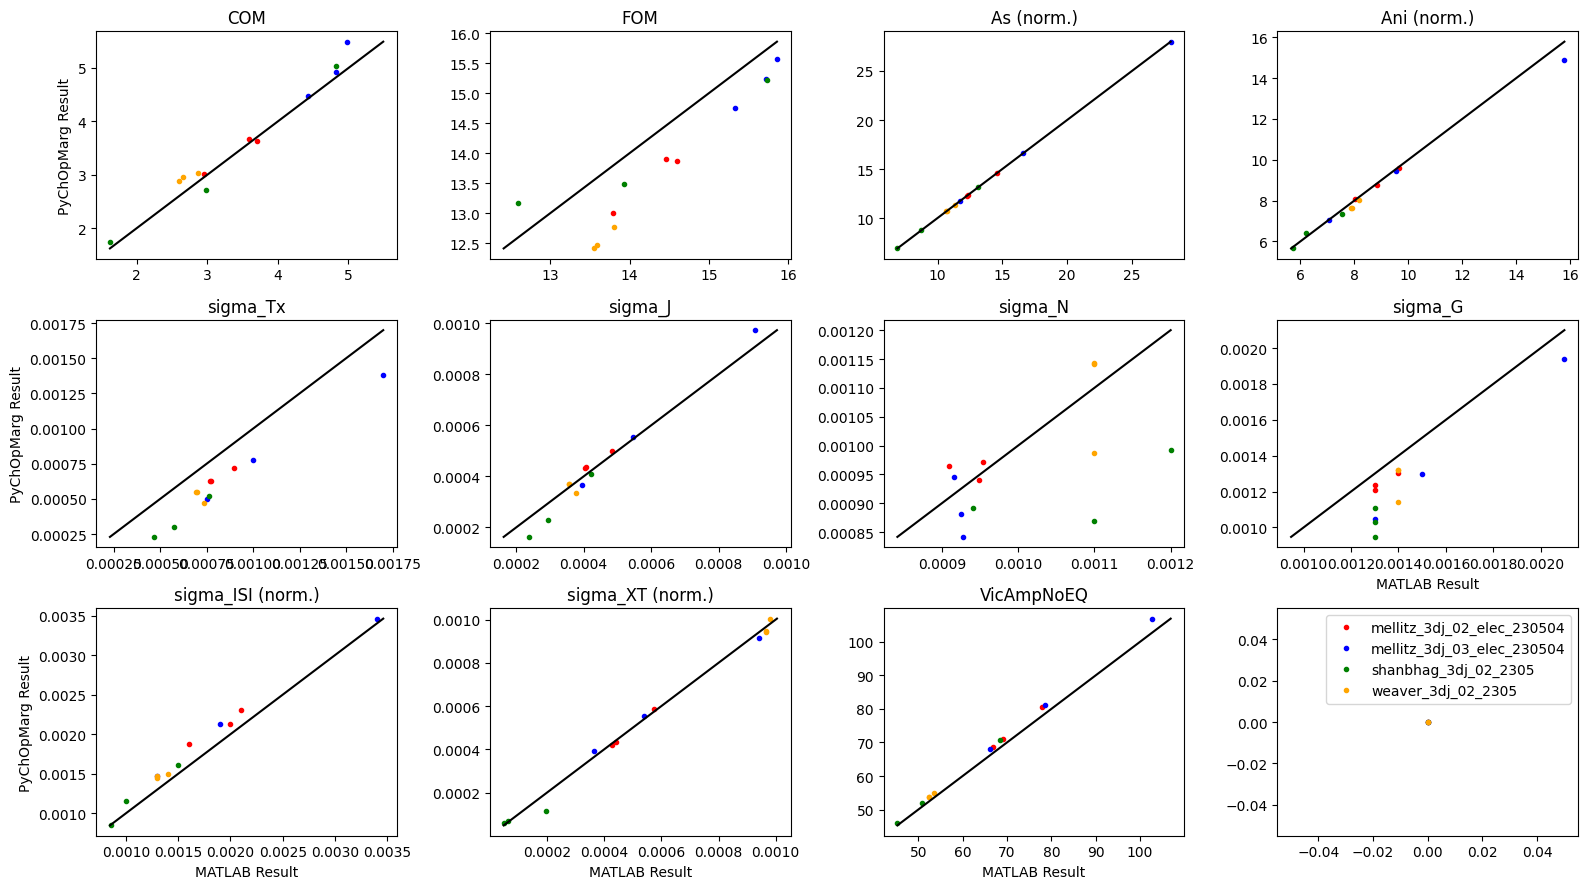

In [13]:
nCols = 4
nRows = ceil((nPlots + 1) / nCols)
lastRowCols = nPlots % nCols

plt.figure(figsize=(4 * nCols, 3 * nRows))

for n in range(nPlots):
    row, col = divmod(n, nCols)
    plt.subplot(nRows, nCols, n + 1)
    xlabel = None
    ylabel = None
    if row == nRows - 1 or lastRowCols and row == nRows - 2 and col >= lastRowCols:
        xlabel = "MATLAB Result"
    if not (n % nCols):
        ylabel = "PyChOpMarg Result"
    min_val = 1e6
    max_val = -1e6
    for grp in matlab_results.keys():
        xs = plot_groups[grp]["plot_xs"][n]
        ys = plot_groups[grp]["plot_ys"][n]
        plt.plot(xs, ys, ".", color=plot_groups[grp]["color"], label=grp)
        _min_val = min(min(xs), min(ys))
        _max_val = max(max(xs), max(ys))
        if _min_val < min_val:
            min_val = _min_val
        if _max_val > max_val:
            max_val = _max_val
    plt.plot([min_val, max_val], [min_val, max_val], "k")
    title = comp_pairs[n][1]
    if title in corrected_items:
        title += " (norm.)"
    plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)

row, col = divmod(nPlots, nCols)
plt.subplot(nRows, nCols, nPlots + 1)
for grp in matlab_results.keys():
    plt.plot(0, 0, ".", color=plot_groups[grp]["color"], label=grp)
plt.legend()

plt.tight_layout()
plt.show()

**Note:** The _PyChOpMarg_ results used in some of the plots above have been normalized by the discrepancy in fully equalized victim pulse response amplitudes.  
(See below.)  
Any such quantities are flagged, via a "(norm.)" suffix in their plot titles, above.

That caveat notwithstanding, the match seems pretty good.


#### Victim Pulse Response

The first thing to check is the fully equalized victim pulse response, since it is the source for so many of the constituents of the COM calculation.  

We'll align the peaks for easier visual comparison.

              mellitz_3dj_02_elec_230504                   mellitz_3dj_03_elec_230504          

/Users/dbanas/prj/PyChOpMarg/.tox/notebook/lib/python3.11/site-packages/pychopmarg/plot.py:138: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.axis(ymin=ymin, ymax=ymax)


            shanbhag_3dj_02_2305             

             weaver_3dj_02_2305              

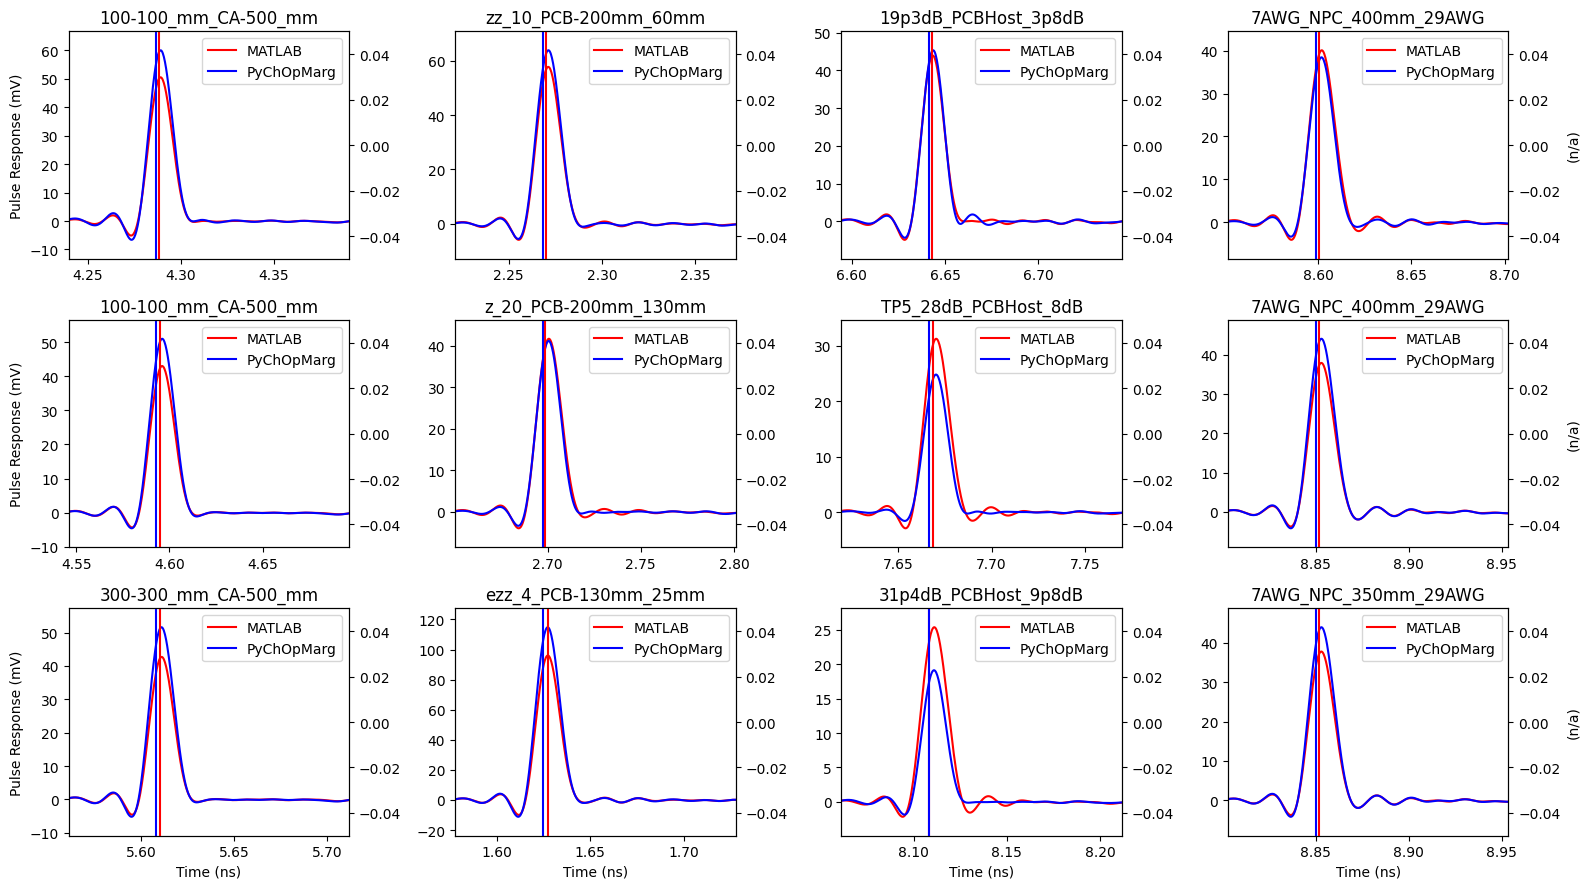

In [14]:
# Align the peaks.
for grp in matlab_results.keys():
    matCOMgrp = matCOMs[grp]
    pyCOMgrp  = theCOMs[grp]
    for chnl in matCOMgrp.keys():
        matCOM = matCOMgrp[chnl]
        pyCOM  = pyCOMgrp[chnl]
        pcom_pk_loc   = pyCOM.times[np.argmax(pyCOM.com_rslts['pulse_resps'][0])]
        matlab_pk_loc = matCOM.times[np.argmax(matCOM.com_rslts['pulse_resps'][0])]
        mat_pk_ofst   = matlab_pk_loc - pcom_pk_loc
        matCOM.t -= mat_pk_ofst

# Plot the pulse responses.
chnls_by_grp: dict[str, list[str]] = plot_group_samps(
    plot_pulse_resps_gen(ZoomMode.PULSE),
    "Time (ns)",
    ("Pulse Response (mV)", "(n/a)"),
    [
        ("MATLAB",     {"color": "red"},  matCOMs),
        ("PyChOpMarg", {"color": "blue"}, theCOMs),
    ],
    dx=4,
    dy=3,
    auto_yscale=True
)


The general shapes are an excellent match.  
However, there are some significant amplitude discrepancies.  
What's causing that?

- [x] Are the MATLAB plots above pre-FFE?

No, I don't think so (starting at line 443):

```matlab
chdata=Apply_EQ(param,fom_result,chdata,OP);
PSD_results=[]; % need to define because passed to Create_Noise_PDF for backward compatability
if (strcmp(OP.FFE_OPT_METHOD,'MMSE') && OP.RxFFE)
    OP.WO_TXFFE=1;
    PSD_results.w=fom_result.RxFFE;
    %  chdata(1).eq_pulse_response includes rx FFE from Apply_EQ as
    %  well as CTLE (CTF) and tx FFE
    PSD_results.S_rn=fom_result.PSD_results.S_rn; % get_PSDs will adjust S_rn for Rxffe
    % at this point chdata(1).eq_pulse_response has the tx and rx FFE and CTF applied
```

and:

```matlab
9189 OP.FFE_OPT_METHOD=xls_parameter(parameter,'FFE_OPT_METHOD',false,'MMSE'); % 'MMSE','FV-LMS'
```


#### Unequalized Pulse Responses

Let's take a look at the unequalized victim pulse responses, to see if they have this same amplitude mismatch.  
We'll need to realign the time vectors first, as the delays through the Rx FFE filter are not the same; not sure why.


              mellitz_3dj_02_elec_230504                   mellitz_3dj_03_elec_230504          

            shanbhag_3dj_02_2305             

             weaver_3dj_02_2305              

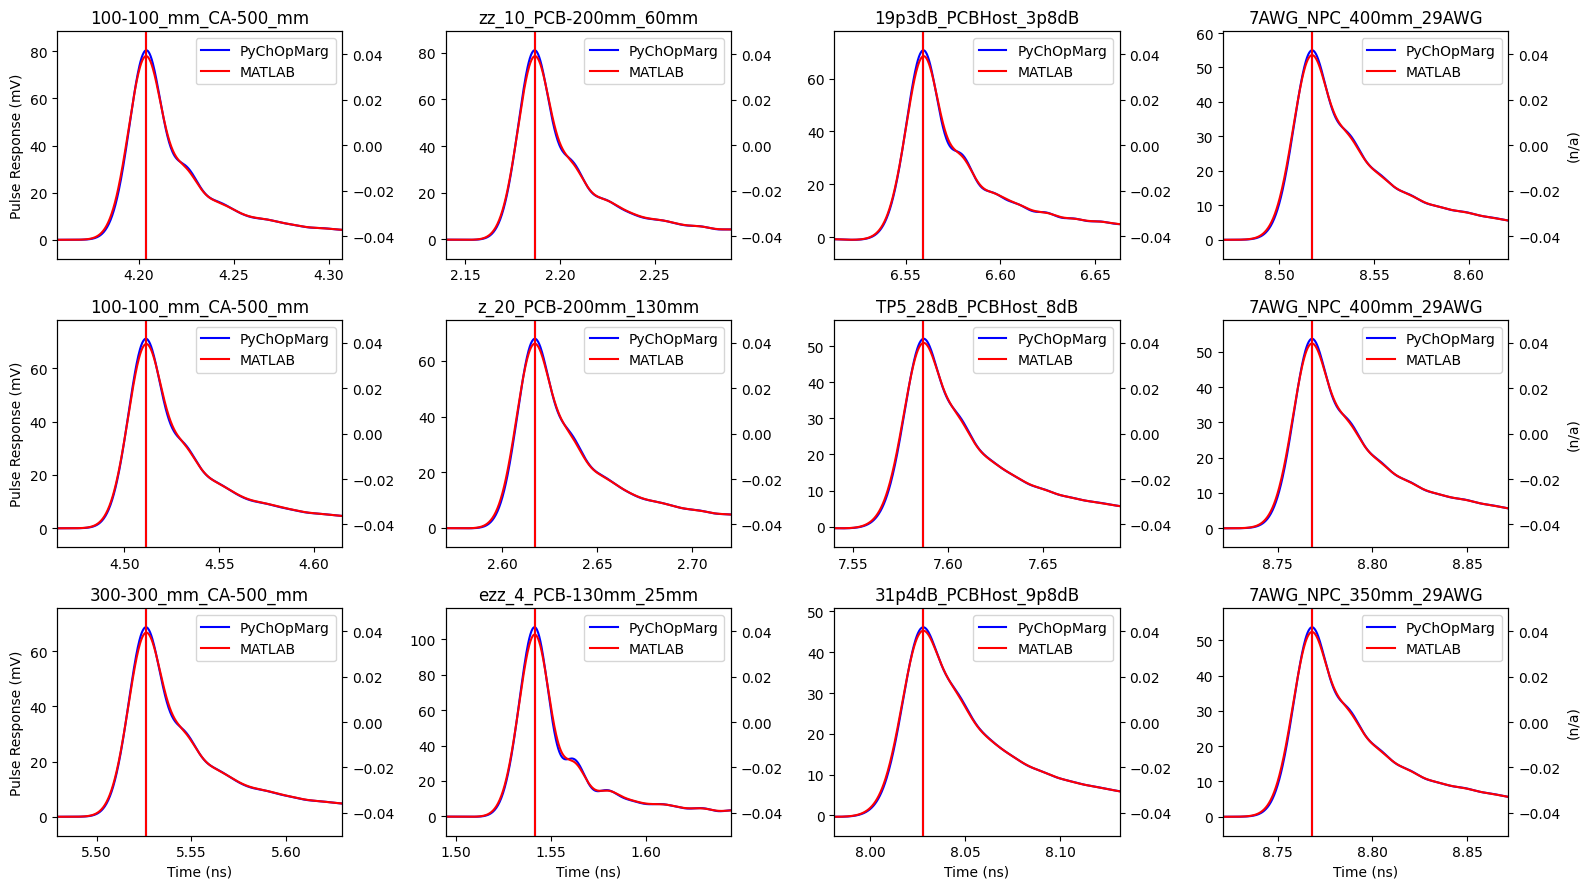

In [15]:
for grp in matlab_results.keys():
    matCOMgrp = matCOMs[grp]
    theCOMgrp = theCOMs[grp]
    for chnl in matCOMgrp.keys():
        matCOM = matCOMgrp[chnl]
        theCOM = theCOMgrp[chnl]
        matlab_pk_loc = matCOM.times[np.argmax(matCOM.pulse_resps_noeq[0])]
        pcom_pk_loc   = theCOM.times[np.argmax(theCOM.pulse_resps_noeq[0])]
        matCOM.t -= matlab_pk_loc - pcom_pk_loc

_ = plot_group_samps(
    plot_pulse_resps_gen(ZoomMode.PULSE, noeq=True),
    "Time (ns)",
    ("Pulse Response (mV)", "(n/a)"),
    [("PyChOpMarg", {"color": "blue"}, theCOMs),
     ("MATLAB",     {"color": "red"},  matCOMs),
    ],
    dx=4,
    dy=3,
    chnls_by_grp=chnls_by_grp,
    auto_yscale=True
)


The pulse response amplitudes are nearly identical.  
So, the amplitude difference in the equalized case is due to the equalization, which consists only of the Rx FFE and a single DFE tap here, since I've completely disabled the Tx FFE and Rx CTLE in the configuration spreadsheet.

Let's compare the Rx FFE tap weight solutions...

#### Rx FFE Tap Weights

I'm having a problem comparing the Rx FFE tap weight solutions, because the MATLAB output contains just:

```
'RxFFE': '[16x1 double]'
```

Perusing the MATLAB code:

```matlab
2562 if OP.RxFFE
2563     output_args.RxFFE=fom_result.RxFFE;
2564     output_args.RxFFEgain=param.current_ffegain;
2565 else % Yasou Hidaka 11/20/2018 help to align csv file columns
2566     output_args.RxFFE=[];
2567     output_args.RxFFEgain=[];
2568 end
```

and:

```matlab
735 if nargout==0
736     fprintf('<strong>--- Testcase %d results ---</strong>\n', package_testcase_i);
737     disp(output_args)
738 end
```

**Note:** I can't find anywhere in the MATLAB code where the variable `nargout` is assigned a value.
And I'm assuming that an unassigned variable has default value zero and, thus, that the `if` block above is getting executed.
Also, line 736 is the only one I can find that prints, "...Testcase %d results...".
And I know that's happening, because I see it in the MATLAB output.

I know that `disp()` and `display()` behave differently.  
What happens if I replace line 737 with:

```matlab
737     display(output_args)
```

?

==> No joy; still getting: '[16x1 double]'. (See above.)

Okay, this change seems to work:

```matlab
738 % dbanas - To get the Rx FFE tap weights printed out.
739 fprintf('RxFFE:');
740 for i=1:length(output_args.RxFFE)
741     fprintf(' %5.3f', output_args.RxFFE(i));
742 end
fprintf('\n');
```


              mellitz_3dj_02_elec_230504                   mellitz_3dj_03_elec_230504          

            shanbhag_3dj_02_2305             

             weaver_3dj_02_2305              

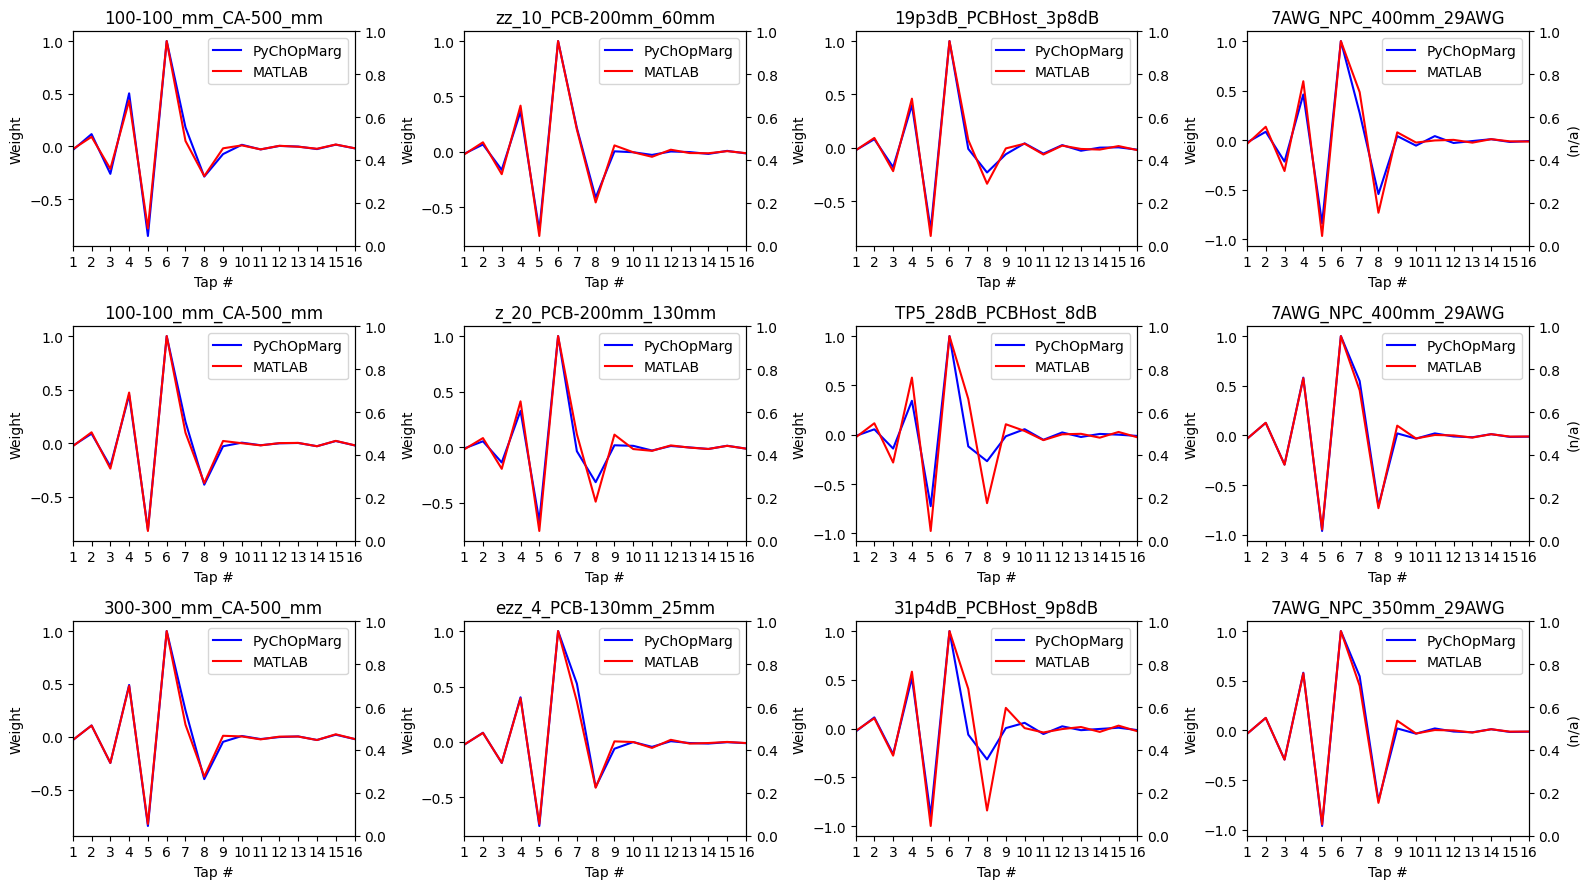

In [16]:
def plot_ffe_weights(com: COM, grp: str, lbl: str, nm: str, opts: dict[str, str], ax1: Any, ax2: Any) -> None:
    "Plot and compare Rx FFE tap weights."
    nTaps    = com.nRxTaps
    if not nTaps:
        nTaps = 1
    nPreTaps = com.nRxPreTaps
    tap_ix   = np.arange(nTaps) + 1
    clr = opts["color"]
    ax1.plot(tap_ix, com.rx_taps, label=nm, color=clr)
    plt.title(f"{lbl[-25:-5]}")
    ax1.set_xlabel("Tap #")
    ax1.set_ylabel("Weight")
    plt.axis(xmin=1, xmax=16)
    ax1.xaxis.set_major_locator(MultipleLocator(1))
    ax1.grid(which='major', axis='x')
    ax1.legend()

_ = plot_group_samps(
    plot_ffe_weights,
    "Tap #",
    ("Weight", "(n/a)"),
    [
        ("PyChOpMarg", {"color": "blue"}, theCOMs),
        ("MATLAB",     {"color": "red"},  matCOMs),
    ],
    dx=4,
    dy=3,
    chnls_by_grp=chnls_by_grp
)


**Note:** The comment below is no longer necessarily true.
It has been left in place, as part of the historical debugging record.

In general, the agreement seems excellent.  
However, the first post-cursor tap (tap #7 in the plots above) is consistently larger in the _PyChOpMarg_ case.  
And that could explain the larger equalized pulse response amplitude seen above.

#### Rx DFE Tap Weights

The fact that the first post-cursor tap in the plots above is consistently larger draws the DFE tap weight solution into suspicion.

Let's see how the DFE tap weights compare...

In [17]:
print("DFE Tap Weights\t\t\t\t\t\tPyChOpMarg\tMATLAB")
print("="*78)
for grp in sorted(theCOMs.keys()):
    print(f"{grp:32s}:")
    for chnl in sorted(theCOMs[grp].keys()):
        print(f"\t{chnl[-45: -5]:40s}:\t  {theCOMs[grp][chnl].dfe_taps}\t{matCOMs[grp][chnl].dfe_taps}")


DFE Tap Weights						PyChOpMarg	MATLAB
mellitz_3dj_02_elec_230504      :
	_11_PCB-50-50_mm_FO-100-100_mm_CA-500_mm:	  [0.55]	[0.6]
	_12_PCB-75-75_mm_FO-100-100_mm_CA-500_mm:	  [0.71]	[0.65]
	_16_PCB-25-25_mm_FO-300-300_mm_CA-500_mm:	  [0.65]	[0.62]
mellitz_3dj_03_elec_230504      :
	C2C_withXtalk_Mezz_10_PCB-200mm_60mm    :	  [0.68]	[0.63]
	C2C_withXtalk_Mezz_20_PCB-200mm_130mm   :	  [0.69]	[0.69]
	C2C_withXtalk_Mezz_4_PCB-130mm_25mm     :	  [0.62]	[0.58]
shanbhag_3dj_02_2305            :
	R_1mCabledBP_TP0TP5_19p3dB_PCBHost_3p8dB:	  [0.45]	[0.46]
	KR_1mCabledBP_TP0TP5_28dB_PCBHost_8dB   :	  [0.77]	[0.73]
	R_1mCabledBP_TP0TP5_31p4dB_PCBHost_9p8dB:	  [0.6]	[0.81]
weaver_3dj_02_2305              :
	0mm_29AWG_BP_800mm_27AWG_NPC_400mm_29AWG:	  [0.71]	[0.71]
	0mm_29AWG_BP_800mm_27AWG_NPC_400mm_29AWG:	  [0.72]	[0.72]
	0mm_29AWG_BP_800mm_27AWG_NPC_350mm_29AWG:	  [0.72]	[0.72]


I don't see any eggregious mismatches.


#### Cursor Location

The cursor locations, visible in both the equalized and unequalized pulse response plots above, appear to match very well.  
Let's just print them out in tabular form, for reference.

**Note:** The values printed below are _offsets_ relative to the peak.

In [18]:
print("Cursor Offset\t\t\t\t\t\tPyChOpMarg\tMATLAB")
print("="*78)
for grp in sorted(theCOMs.keys()):
    print(f"{grp:32s}:")
    for chnl in sorted(theCOMs[grp].keys()):
        # py_curs_ofst  = theCOMs[grp][chnl].fom_rslts['cursor_ix'] - theCOMs[grp][chnl].fom_rslts['vic_peak_loc']
        # mat_curs_ofst = matCOMs[grp][chnl].fom_rslts['cursor_ix'] - matCOMs[grp][chnl].fom_rslts['vic_peak_loc']
        py_curs_ofst  = theCOMs[grp][chnl].com_rslts['cursor_ix'] - np.argmax(theCOMs[grp][chnl].com_rslts['pulse_resps'][0])
        mat_curs_ofst = matCOMs[grp][chnl].com_rslts['cursor_ix'] - np.argmax(matCOMs[grp][chnl].com_rslts['pulse_resps'][0])
        print(f"\t{chnl[-45: -5]:40s}:\t  {py_curs_ofst:6d}\t{mat_curs_ofst:6d}")


Cursor Offset						PyChOpMarg	MATLAB
mellitz_3dj_02_elec_230504      :
	_11_PCB-50-50_mm_FO-100-100_mm_CA-500_mm:	      -8	    -3
	_12_PCB-75-75_mm_FO-100-100_mm_CA-500_mm:	     -11	    -4
	_16_PCB-25-25_mm_FO-300-300_mm_CA-500_mm:	     -10	    -3
mellitz_3dj_03_elec_230504      :
	C2C_withXtalk_Mezz_10_PCB-200mm_60mm    :	     -10	    -3
	C2C_withXtalk_Mezz_20_PCB-200mm_130mm   :	     -11	    -7
	C2C_withXtalk_Mezz_4_PCB-130mm_25mm     :	      -9	     1
shanbhag_3dj_02_2305            :
	R_1mCabledBP_TP0TP5_19p3dB_PCBHost_3p8dB:	      -7	    -1
	KR_1mCabledBP_TP0TP5_28dB_PCBHost_8dB   :	     -13	    -6
	R_1mCabledBP_TP0TP5_31p4dB_PCBHost_9p8dB:	      -9	    -9
weaver_3dj_02_2305              :
	0mm_29AWG_BP_800mm_27AWG_NPC_400mm_29AWG:	     -11	    -4
	0mm_29AWG_BP_800mm_27AWG_NPC_400mm_29AWG:	     -11	    -4
	0mm_29AWG_BP_800mm_27AWG_NPC_350mm_29AWG:	     -11	    -4


There is clearly a systemic left shift in the _PyChOpMarg_ cursor locations, relative to the MATLAB equivalents.  
And I've noticed that they go away if I disable the DFE.

- [ ] What is causing this?

**==> Jan. 19, 2025** Clearly, I have my next line of inquiry into the source of the remaining discrepancy between _PyChOpMarg_ and the COM M-code well defined.
However, I'm going to stop here and get this next release published, for the benefit of those wishing to participate in the code development.

#### Noise & Interference PMFs

Here, we look at the difference in the noise and interference PMFs used to calculate $A_{ni}$.


              mellitz_3dj_02_elec_230504          

/var/folders/pf/9gjf96y54f55tdz0vt0wq4kh0000gn/T/ipykernel_83527/1578310537.py:7: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax1.semilogy(y * 1e3, com.com_rslts['pJ'],   label="pJ",   color="blue",   linestyle=opts["linestyle"])


         mellitz_3dj_03_elec_230504          

            shanbhag_3dj_02_2305             

             weaver_3dj_02_2305              

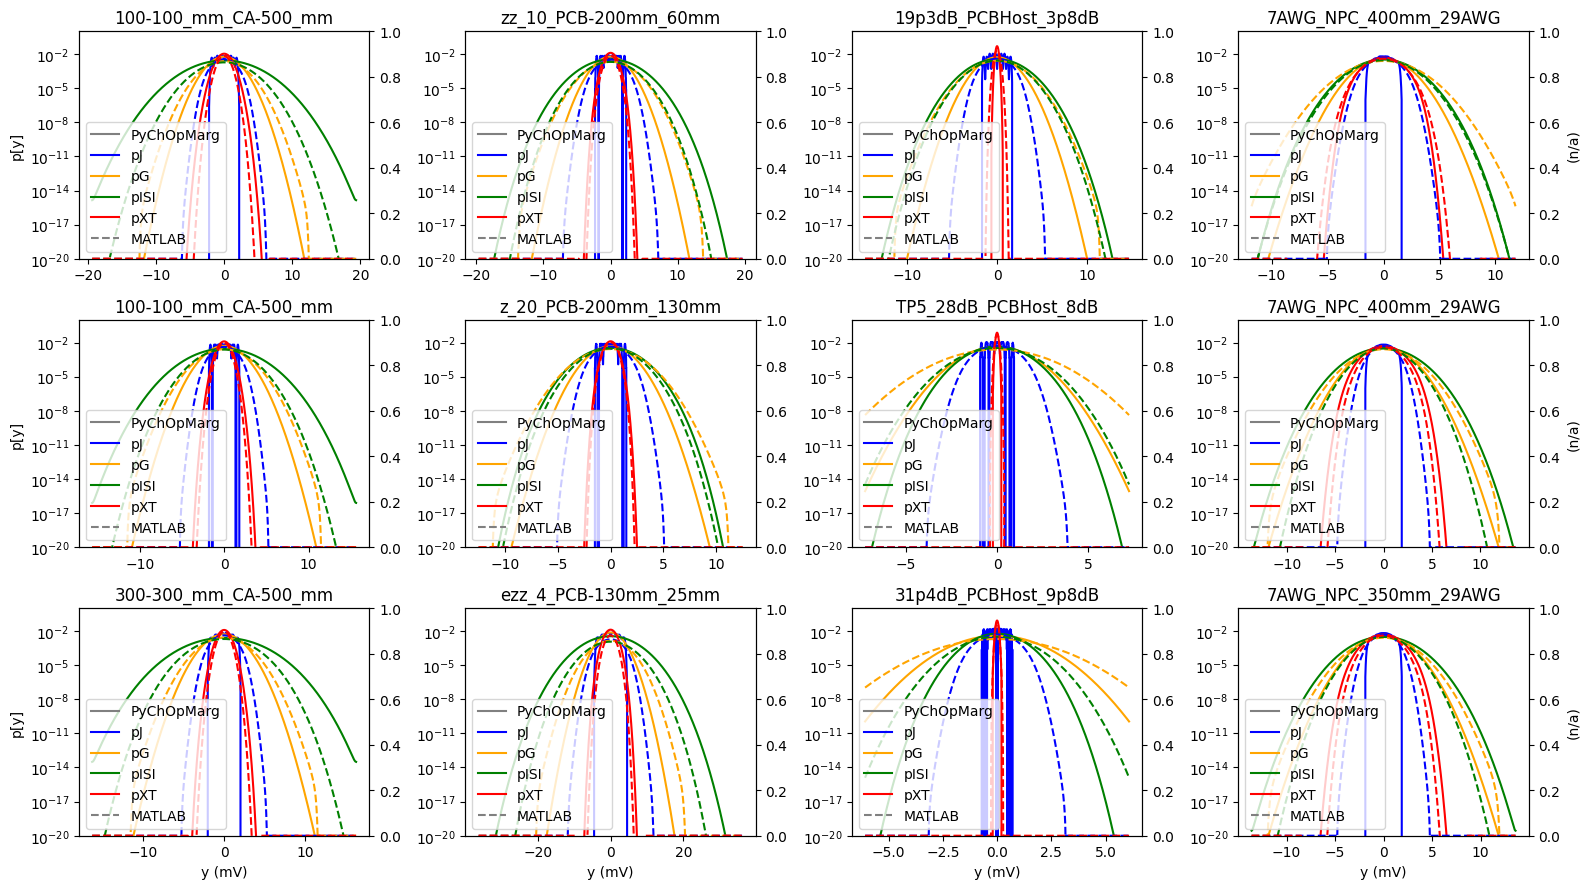

In [19]:
def plot_pmfs(com: COM, grp: str, lbl: str, nm: str, opts: dict[str, str], ax1: Any, ax2: Any) -> None:
    "Plot various components of the noise & interference PMF."
    ax1.plot([0, 1], [0, 0], label=nm, color="gray", linestyle=opts["linestyle"])  # Just for legend.
    if nm == "MATLAB":
        ax1.legend(loc="lower left")
    y = com.com_rslts["y"]
    ax1.semilogy(y * 1e3, com.com_rslts['pJ'],   label="pJ",   color="blue",   linestyle=opts["linestyle"])
    ax1.semilogy(y * 1e3, com.com_rslts['pG'],   label="pG",   color="orange", linestyle=opts["linestyle"])
    ax1.semilogy(y * 1e3, com.com_rslts['pISI'], label="pISI", color="green",  linestyle=opts["linestyle"])
    ax1.semilogy(y * 1e3, com.com_rslts['pXT'],  label="pXT",  color="red",    linestyle=opts["linestyle"])
    ax1.axis(ymin=1e-20, ymax=1)
    ax1.grid()
    plt.title(f"{lbl[-25: -5]}")

_ = plot_group_samps(
    plot_pmfs,
    "y (mV)",
    ("p[y]", "(n/a)"),
    [("PyChOpMarg", {"linestyle": "solid"},  theCOMs),
     ("MATLAB",     {"linestyle": "dashed"}, matCOMs),
    ],
    dx=4,
    dy=3,
    chnls_by_grp=chnls_by_grp
)


My ISI is still running high, relative to the MATLAB code, but is no longer "out of control".  
And we're seeing the thermal noise return to dominance in several of the tested cases, which I believe is what we expect in most non-cryogenic systems.

## Conclusion

The testing above is _very_ preliminary and needs to be expanded significantly.  
However, these initial results are encouraging.
We appear to be "in the ballpark".
